In [82]:
import numpy as np
import pandas as pd
import itertools
from itertools import cycle
import re

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster import rand_score

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance_matrix
from scipy.stats import pearsonr
from scipy import stats
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

import mantel

#import kaleido
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.io as pio

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker
import matplotlib.colors as clr
import matplotlib.cm as cm

## Loading and sanitizing the data

In [2]:
df_vd3_src_l1 = pd.read_csv('geodes_l1.csv', sep=',', decimal='.')
df_vd3_src_l2 = pd.read_csv('geodes_l2.csv', sep=',', decimal='.')
df_vd3_src_l3 = pd.read_csv('geodes_l3.csv', sep=',', decimal='.')

In [3]:
# helices boundaries reference for hVDR
ref = np.array([[127,142], [149,152], [218,222], [226,246], [257,265], [268, 278], [298,302], [308,322], [328,338], [350,369], [379,396], [397,406], [411,413], [417,423]]).flatten()

In [4]:
data = {'df_vd3_src_l1': df_vd3_src_l1,
        'df_vd3_src_l2': df_vd3_src_l2,
        'df_vd3_src_l3': df_vd3_src_l3
        }

In [5]:
dssp_cols_new = []
dssp_cols = data['df_vd3_src_l1'].filter(regex=("DSSP")).columns

dssp_cols_num = dssp_cols.str.replace("H3", "H3n")
for i in range(4, 13):
  dssp_cols_num = dssp_cols_num.str.replace(f"H{i}", f"H{i-1}")

dssp_cols_num = dssp_cols_num.str.replace("H13", "Hx")
dssp_cols_num = dssp_cols_num.str.replace("H14", "H12")

for i in range(14):
  if i<2:
    dssp_cols_new.append('DSSP start_H'+str(i+1))
    dssp_cols_new.append('DSSP end_H'+str(i+1))
  elif i == 2:
    dssp_cols_new.append('DSSP start_H3n')
    dssp_cols_new.append('DSSP end_H3n')
  elif i>2 and i<12:
    dssp_cols_new.append('DSSP start_H'+str(i))
    dssp_cols_new.append('DSSP end_H'+str(i))
  elif i == 12:
    dssp_cols_new.append('DSSP start_Hx')
    dssp_cols_new.append('DSSP end_Hx')
  else:
    dssp_cols_new.append('DSSP start_H12')
    dssp_cols_new.append('DSSP end_H12')

dssp_rename = dict(zip(dssp_cols_num, dssp_cols_new))

In [6]:
for name, df in data.items():
  df = df.drop(['Unnamed: 0'], axis=1)
  df['prot_name'] = df['prot_name'].map(lambda x: re.sub(r'.*-auto_', '', x))
  df['prot_name'] = df['prot_name'].map(lambda x: x.replace('.pdb', ''))
  df = df.astype({'prot_name': 'int32'})
  df = df.sort_values(by=['prot_name'], ignore_index=True).rename(columns={"prot_name": "frame"})
  df.columns = df.columns.str.replace("H3", "H3n")

  for i in range(4, 13):
    df.columns = df.columns.str.replace(f"H{i}", f"H{i-1}")

  df.columns = df.columns.str.replace("H13", "Hx")
  df.columns = df.columns.str.replace("H14", "H12")

  df = df.rename(columns=dssp_rename)

  data.update({name: df})

In [7]:
data['df_vd3_src_l1'].head()

,frame,Dist prot-H1,Dist prot-H2,Dist prot-H3n,Dist prot-H3,Dist prot-H4,Dist prot-H5,Dist prot-H6,Dist prot-H7,Dist prot-H8,...,DSSP end_H9,DSSP start_H10,DSSP end_H10,DSSP start_H11,DSSP end_H11,DSSP start_Hx,DSSP end_Hx,DSSP start_H12,DSSP end_H12,N_res extra helical
0,0,17.498402,19.076990,28.664629,8.779440,17.344360,4.633159,20.901125,16.262236,11.416581,...,370,379,396,397,405,410,412,418,421,6
1,1,17.608702,19.392324,29.129229,8.696710,17.059250,4.561357,20.784674,15.509317,11.385230,...,369,380,396,397,404,410,412,416,422,6
2,2,17.763506,19.208082,27.356197,8.509413,17.053493,4.717549,21.126010,15.380616,11.237886,...,369,379,396,397,404,0,0,416,421,6
3,3,18.109047,18.899027,27.416252,8.942605,17.735039,4.540847,20.741625,15.418817,11.483450,...,370,379,396,397,405,410,413,418,421,6
4,4,18.155642,18.902773,27.108805,9.127436,17.359402,4.440572,20.622066,15.553366,11.210203,...,369,379,396,397,405,411,413,416,422,3


In [8]:
def deltaTransform(x, ref):
  for i in range(len(x)):
    if i%2 == 0:
      x.iloc[i] = (ref[i]-x.iloc[i])
    else:
      x.iloc[i] = (x.iloc[i]-ref[i])
  return x

def unique_cols(df):
    a = df.to_numpy()
    return (a[0] == a).all(0)

In [9]:
cols = np.array(data['df_vd3_src_l1'].filter(regex=("DSSP")).columns)
transformed_data = dict()

for name, df in data.items():
  temp_df = df.copy()
  temp_df[cols] = temp_df[cols].apply(lambda x: deltaTransform(x, ref), axis=1)
  idx,  = np.where(unique_cols(df) == True)
  same_vals = df.iloc[:, idx].columns.tolist()
  delete_list=[]
  temp_df = temp_df.drop(delete_list, axis=1)
  transformed_data.update({name:temp_df})

In [10]:
transformed_data['df_vd3_src_l1']

,frame,Dist prot-H1,Dist prot-H2,Dist prot-H3n,Dist prot-H3,Dist prot-H4,Dist prot-H5,Dist prot-H6,Dist prot-H7,Dist prot-H8,...,DSSP end_H9,DSSP start_H10,DSSP end_H10,DSSP start_H11,DSSP end_H11,DSSP start_Hx,DSSP end_Hx,DSSP start_H12,DSSP end_H12,N_res extra helical
0,0,17.498402,19.076990,28.664629,8.779440,17.344360,4.633159,20.901125,16.262236,11.416581,...,1,0,0,0,-1,1,-1,-1,-2,6
1,1,17.608702,19.392324,29.129229,8.696710,17.059250,4.561357,20.784674,15.509317,11.385230,...,0,-1,0,0,-2,1,-1,1,-1,6
2,2,17.763506,19.208082,27.356197,8.509413,17.053493,4.717549,21.126010,15.380616,11.237886,...,0,0,0,0,-2,411,-413,1,-2,6
3,3,18.109047,18.899027,27.416252,8.942605,17.735039,4.540847,20.741625,15.418817,11.483450,...,1,0,0,0,-1,1,0,-1,-2,6
4,4,18.155642,18.902773,27.108805,9.127436,17.359402,4.440572,20.622066,15.553366,11.210203,...,0,0,0,0,-1,0,0,1,-1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96,17.030731,19.663542,27.178394,9.141317,16.926289,5.075649,21.175108,15.696199,11.654580,...,0,0,0,0,-2,1,0,1,-2,6
97,97,17.072447,19.231226,26.651058,9.632739,16.963966,5.098431,21.005108,16.012812,11.333541,...,0,0,0,0,-2,1,-1,-1,-2,6
98,98,17.299707,19.566305,26.433600,9.300228,16.397785,5.003243,20.971422,16.240135,11.341949,...,0,0,0,0,0,1,0,1,-2,3
99,99,17.324750,19.527970,27.074593,9.135515,16.632240,5.063313,20.990921,15.878031,11.445569,...,0,-1,0,0,-2,1,0,1,-2,6


In [11]:
scaled_data = dict()
scaler = preprocessing.StandardScaler()

for name, df in transformed_data.items():
  scaled_values = scaler.fit_transform(df)
  scaled_df = pd.DataFrame(scaled_values, columns=transformed_data[name].columns)
  scaled_data.update({name:scaled_df})

## PCA analysis

In [12]:
pca_data = dict()

i=0
for name, df in scaled_data.items():
  i+=1
  temp_pca = PCA(n_components=3).fit_transform(df)
  pca_df = pd.DataFrame()
  pca_df['X'] = temp_pca[:,0]
  pca_df['Y'] = temp_pca[:,1]
  pca_df['Z'] = temp_pca[:,2]
  pca_df['frame'] = data[name]['frame']
  pca_df['motif'] = f'L{i}'
  pca_data.update({name:pca_df})

In [13]:
pdList = [df for df in pca_data.values()]
final_df = pd.concat(pdList)
final_df = final_df.reset_index()
final_df = final_df.drop(['index'], axis=1)

In [14]:
final_df.head(5)

,X,Y,Z,frame,motif
0,-13.516218,-0.503669,-3.931048,0,L1
1,-15.460093,0.130623,-10.693887,1,L1
2,-16.359770,-1.627129,-7.200932,2,L1
3,-11.902873,-0.769889,4.598886,3,L1
4,-9.223341,-3.169681,6.756911,4,L1


In [15]:
fig = px.scatter(final_df,
                    x = 'X',
                    y = 'Y',
                    facet_col='motif',
                    opacity = 0.8,
                    color='frame',
                    color_continuous_scale=px.colors.sequential.Agsunset_r,
                    title="VD3-SRC1 (independent)",
                    width=1400, height=470)

fig.update_traces(marker={'size': 13})
fig.update_layout(template='simple_white')

fig.show()

## Standard deviation (QCD analysis)

In [16]:
stats_l1 = transformed_data['df_vd3_src_l1'].quantile(0.25).to_frame(name='Q1')
stats_l1['Q3'] = transformed_data['df_vd3_src_l1'].quantile(0.75)
stats_l1['IQR'] = stats_l1['Q3']-stats_l1['Q1']
stats_l1['sumQ'] = stats_l1['Q3']+stats_l1['Q1']
stats_l1['QCV'] = np.where(stats_l1['sumQ'] == 0, 0, stats_l1['IQR'] / stats_l1['sumQ'])
stats_l1 = stats_l1.reset_index()
stats_l1 = stats_l1.sort_values(by=['QCV'], ascending=False)
stats_l1 = stats_l1[stats_l1['index'] != 'frame']

stats_l2 = transformed_data['df_vd3_src_l2'].quantile(0.25).to_frame(name='Q1')
stats_l2['Q3'] = transformed_data['df_vd3_src_l2'].quantile(0.75)
stats_l2['IQR'] = stats_l2['Q3']-stats_l2['Q1']
stats_l2['sumQ'] = stats_l2['Q3']+stats_l2['Q1']
stats_l2['QCV'] = np.where(stats_l2['sumQ'] == 0, 0, stats_l2['IQR'] / stats_l2['sumQ'])
stats_l2 = stats_l2.reset_index()
stats_l2 = stats_l2.sort_values(by=['QCV'], ascending=False)
stats_l2 = stats_l2[stats_l2['index'] != 'frame']

stats_l3 = transformed_data['df_vd3_src_l3'].quantile(0.25).to_frame(name='Q1')
stats_l3['Q3'] = transformed_data['df_vd3_src_l3'].quantile(0.75)
stats_l3['IQR'] = stats_l3['Q3']-stats_l3['Q1']
stats_l3['sumQ'] = stats_l3['Q3']+stats_l3['Q1']
stats_l3['QCV'] = np.where(stats_l3['sumQ'] == 0, 0, stats_l3['IQR'] / stats_l3['sumQ'])
stats_l3 = stats_l3.reset_index()
stats_l3 = stats_l3.sort_values(by=['QCV'], ascending=False)
stats_l3 = stats_l3[stats_l3['index'] != 'frame']

In [17]:
stats_l1

,index,Q1,Q3,IQR,sumQ,QCV
156,Angle H2-H11,3.521922,7.680737,4.158815,11.202659,0.371235
284,N_res extra helical,3.000000,6.000000,3.000000,9.000000,0.333333
195,Angle H5-Hx,6.401226,12.661896,6.260670,19.063122,0.328418
155,Angle H2-H10,6.473114,11.375910,4.902796,17.849024,0.274681
219,Angle H10-H11,7.565093,11.046835,3.481742,18.611928,0.187070
...,...,...,...,...,...,...
257,DSSP end_H1,-2.000000,0.000000,2.000000,-2.000000,-1.000000
281,DSSP end_Hx,-1.000000,0.000000,1.000000,-1.000000,-1.000000
267,DSSP end_H5,-1.000000,0.000000,1.000000,-1.000000,-1.000000
260,DSSP start_H3n,-2.000000,1.000000,3.000000,-1.000000,-3.000000


In [18]:
stats_l1['motif'] = 'L1'
stats_l2['motif'] = 'L2'
stats_l3['motif'] = 'L3'
stats_all = pd.concat([stats_l1, stats_l2, stats_l3])

In [19]:
import plotly.express as px

df = stats_all

fig = px.violin(df, y="QCV", color='motif', box=True,
                points=False,  color_discrete_sequence=["#faa920", "#1b9894", "#90c73d"]
               )

fig.update_layout(template='plotly_white',
    legend=dict(font=dict(size=14),
                title="",
                orientation="h",
                yanchor="top",
                y=1.15,
                xanchor="left",
                x=0.01),
                yaxis = dict(tickfont = dict(size=14)),
                yaxis_title="QCD",
    width=700,
    height=400)

fig.show()

In [20]:
q3_l1 = stats_l1["QCV"][stats_l1["QCV"]>=stats_l1["QCV"].quantile(0.75)]
q3_l2 = stats_l2["QCV"][stats_l2["QCV"]>=stats_l2["QCV"].quantile(0.75)]
q3_l3 = stats_l3["QCV"][stats_l3["QCV"]>=stats_l3["QCV"].quantile(0.75)]

q1_l1 = stats_l1["QCV"][stats_l1["QCV"]<=stats_l1["QCV"].quantile(0.25)]
q1_l2 = stats_l2["QCV"][stats_l2["QCV"]<=stats_l2["QCV"].quantile(0.25)]
q1_l3 = stats_l3["QCV"][stats_l3["QCV"]<=stats_l3["QCV"].quantile(0.25)]

# can be written to xsls
# stats_l1.head(q3_l1)[['index','QCV']].to_excel('stats_l1_head.xlsx')
# stats_l2.head(q3_l2)[['index','QCV']].to_excel('stats_l1_head.xlsx')
# stats_l3.head(q3_l3)[['index','QCV']].to_excel('stats_l1_head.xlsx')

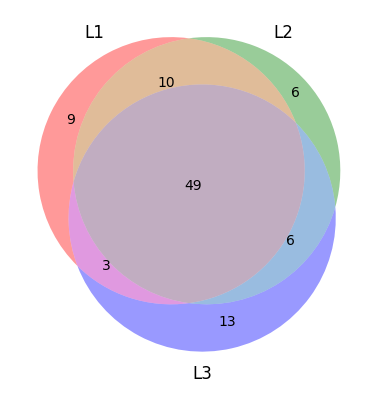

In [21]:
from matplotlib_venn import venn3

s1_stable = set(stats_l1.tail(len(q1_l1))['index'].to_list())
s2_stable = set(stats_l2.tail(len(q1_l2))['index'].to_list())
s3_stable = set(stats_l3.tail(len(q1_l3))['index'].to_list())

# Use the venn2 function
venn3([s1_stable, s2_stable, s3_stable], set_labels = ('L1', 'L2', 'L3'))
plt.show()

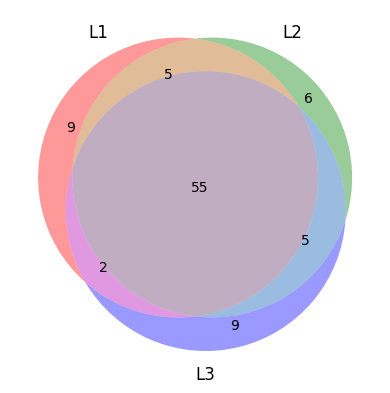

In [22]:
s1_flex = set(stats_l1.head(len(q3_l1))['index'].to_list())
s2_flex = set(stats_l2.head(len(q3_l2))['index'].to_list())
s3_flex = set(stats_l3.head(len(q3_l3))['index'].to_list())

venn3([s1_flex, s2_flex, s3_flex], set_labels = ('L1', 'L2', 'L3'))
plt.show()

### Trajectory-specific feature analysis

In [23]:
# extracting trajectory-specific flexible features for l1, l2, l3

bot_q3_l1 = stats_l1.tail(len(q3_l1))['index'].to_list()
bot_q3_l2 = stats_l2.tail(len(q3_l2))['index'].to_list()
bot_q3_l3 = stats_l3.tail(len(q3_l3))['index'].to_list()

tmp_l1 = [elem for elem in bot_q3_l1 if elem not in bot_q3_l2 and elem not in bot_q3_l3]
subset = stats_l1[stats_l1['index'].isin(tmp_l1)][['index', 'QCV']]
l1_spec_flex = [tuple(x) for x in subset.to_numpy()]

tmp_l2 = [elem for elem in bot_q3_l2 if elem not in bot_q3_l1 and elem not in bot_q3_l3]
subset = stats_l2[stats_l2['index'].isin(tmp_l2)][['index', 'QCV']]
l2_spec_flex = [tuple(x) for x in subset.to_numpy()]


tmp_l3 = [elem for elem in bot_q3_l3 if elem not in bot_q3_l2 and elem not in bot_q3_l1]
subset = stats_l3[stats_l3['index'].isin(tmp_l3)][['index', 'QCV']]
l3_spec_flex = [tuple(x) for x in subset.to_numpy()]

In [24]:
# extracting trajectory-specific stable features for l1, l2, l3

top_q1_l1 = stats_l1.head(len(q3_l1))['index'].to_list()
top_q1_l2 = stats_l2.head(len(q3_l2))['index'].to_list()
top_q1_l3 = stats_l3.head(len(q3_l3))['index'].to_list()

tmp_l1 = [elem for elem in top_q1_l1 if elem not in top_q1_l2 and elem not in top_q1_l3]
subset = stats_l1[stats_l1['index'].isin(tmp_l1)][['index', 'QCV']]
l1_spec_stable = [tuple(x) for x in subset.to_numpy()]

tmp_l2 = [elem for elem in top_q1_l2 if elem not in top_q1_l1 and elem not in top_q1_l3]
subset = stats_l2[stats_l2['index'].isin(tmp_l2)][['index', 'QCV']]
l2_spec_stable = [tuple(x) for x in subset.to_numpy()]


tmp_l3 = [elem for elem in top_q1_l3 if elem not in top_q1_l2 and elem not in top_q1_l1]
subset = stats_l3[stats_l3['index'].isin(tmp_l3)][['index', 'QCV']]
l3_spec_stable = [tuple(x) for x in subset.to_numpy()]

### Shared features analysis

In [25]:
shared_names = sorted(list(s1_flex&s2_flex&s3_flex))
shared_dict_flex = {}

shared_dict_flex['names'] = sorted(list(s1_flex&s2_flex&s3_flex))
shared_dict_flex['L1'] = [stats_l1[stats_l1['index']==elem]['QCV'].values[0] for elem in shared_names]
shared_dict_flex['L2'] = [stats_l2[stats_l2['index']==elem]['QCV'].values[0] for elem in shared_names]
shared_dict_flex['L3'] = [stats_l3[stats_l3['index']==elem]['QCV'].values[0] for elem in shared_names]

shared_df_flex = pd.DataFrame.from_dict(shared_dict_flex)

In [26]:
fig = px.bar(pd.melt(shared_df_flex, id_vars=['names'], value_vars=['L1', 'L2', 'L3']), x='names', y='value',
             barmode='group', color='variable', color_discrete_sequence=['#faa920', '#1b9894', '#90c73d'])


fig.update_layout(template='plotly_white',
                  legend=dict(font=dict(size=14),
                    title="",
                    orientation="h",
                    yanchor="top",
                    y=1.15,
                    xanchor="left",
                    x=0.01),
                  yaxis_title="QCD",
                  yaxis = dict(tickfont = dict(size=14)),
                  font=dict(size=12),
                  xaxis_title="",
                  height=500, width=1000)

fig.show()

In [27]:
shared_names = sorted(list(s1_stable&s2_stable&s3_stable))
shared_dict_stable = {}

shared_dict_stable['names'] = sorted(list(s1_stable&s2_stable&s3_stable))
shared_dict_stable['L1'] = [stats_l1[stats_l1['index']==elem]['QCV'].values[0] for elem in shared_names]
shared_dict_stable['L2'] = [stats_l2[stats_l2['index']==elem]['QCV'].values[0] for elem in shared_names]
shared_dict_stable['L3'] = [stats_l3[stats_l3['index']==elem]['QCV'].values[0] for elem in shared_names]

shared_df_stable = pd.DataFrame.from_dict(shared_dict_stable)

In [28]:
fig = px.bar(pd.melt(shared_df_stable, id_vars=['names'], value_vars=['L1', 'L2', 'L3']), x='names', y='value',
             barmode='group', color='variable', color_discrete_sequence=['#faa920', '#1b9894', '#90c73d'])

fig.update_yaxes(range=[-1, 0.2])


fig.update_layout(template='plotly_white',
                  legend=dict(font=dict(size=14),
                    title="",
                    orientation="h",
                    yanchor="top",
                    y=1.15,
                    xanchor="left",
                    x=0.01),
                  yaxis_title="QCD",
                  yaxis = dict(tickfont = dict(size=14)),
                  font=dict(size=12),
                  xaxis_title="",
                  height=500, width=1000)

fig.show()

## Visualization of selected features

In [29]:
df = transformed_data['df_vd3_src_l2']['AngleCOM H5']

import plotly.graph_objects as go
import numpy as np

fig = px.line(df, x=df.index, y="AngleCOM H5", color_discrete_sequence=['black'])

#fig = px.box(df, y="Angle H5-Hx", color_discrete_sequence=['fuchsia'])

fig.add_trace(go.Scatter(x=[77], y=[119.2689],
                         text=["frame 77"], textposition="bottom center",
                         mode='markers+text', marker=dict(size=[20], color=["mediumvioletred"])))
fig.add_trace(go.Scatter(x=[20], y=[134.9359],
                         text=["frame 20"], textposition="top center",
                         mode='markers+text', marker=dict(size=[20], color=["darkcyan"])))

fig.update_layout(template='plotly_white',
                  xaxis = dict(dtick = 5),
                  font=dict(size=18),
                  yaxis_title="θ COM-H5, °",
                  xaxis_title="frame",
                  showlegend=False,
                  height=600, width=1100)

fig.update_traces(line=dict(color="Black", width=1))

fig.show()

# frame 20 , frame 77

In [30]:
import plotly.graph_objects as go

df = transformed_data['df_vd3_src_l2']['Dist prot-H5']

fig = px.line(df, x=df.index, y="Dist prot-H5", color_discrete_sequence=['black'])

#fig = px.box(df, y="Angle H5-Hx", color_discrete_sequence=['fuchsia'])

fig.add_trace(go.Scatter(x=[78], y=[5.265333],
                         text=["frame 78"], textposition="top center",
                         mode='markers+text', marker=dict(size=[20], color=["mediumvioletred"])))
fig.add_trace(go.Scatter(x=[20], y=[4.099168],
                         text=["frame 20"], textposition="bottom center",
                         mode='markers+text', marker=dict(size=[20], color=["darkcyan"])))

fig.update_layout(template='plotly_white',
                  xaxis = dict(dtick = 5),
                  font=dict(size=18),
                  yaxis_title="Δ COMprot-COMH5, Å",
                  xaxis_title="frame",
                  showlegend=False,
                  height=600, width=1100)

fig.update_traces(line=dict(color="Black", width=1))

fig.show()

# frame 20 , frame 78

## Hierarchical Clustering

### RMSD

In [31]:
l1 = final_df[final_df['motif']=='L1']
l2 = final_df[final_df['motif']=='L2']
l3 = final_df[final_df['motif']=='L3']

In [34]:
# rmsd matrixes for clustering

matrix_l1 = pd.read_csv('rmsd_rmsf/rmsd_matrix_l1.txt', engine ='python', sep='\t', decimal='.', header=None)
matrix_l2 = pd.read_csv('rmsd_rmsf/rmsd_matrix_l2.txt', engine ='python', sep='\t', decimal='.', header=None)
matrix_l3 = pd.read_csv('rmsd_rmsf/rmsd_matrix_l3.txt', engine ='python', sep='\t', decimal='.', header=None)

#### Number of clusters evaluation

For n_clusters = 2 The average silhouette_score is : 0.18697921565932074
For n_clusters = 3 The average silhouette_score is : 0.09598350143393725
For n_clusters = 4 The average silhouette_score is : 0.09508664456835145
For n_clusters = 5 The average silhouette_score is : 0.09466277534683559


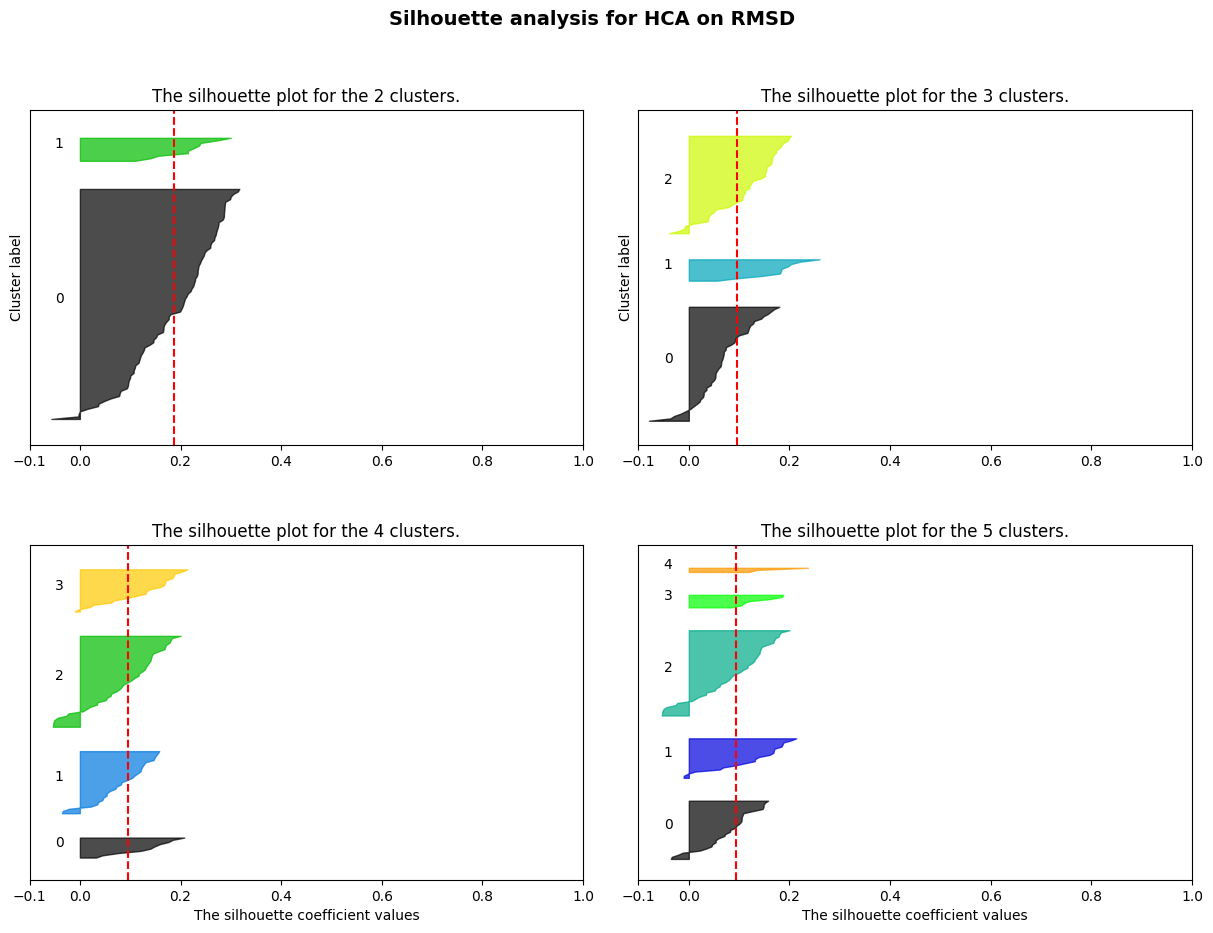

In [33]:
X = matrix_l1

fig, (ax1, ax2) = plt.subplots(2, 2,  figsize=(15, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.1)

range_n_clusters = {ax1[0]: 2, ax1[1]: 3, ax2[0]:  4, ax2[1]: 5}

for ax_n, n_clusters in range_n_clusters.items():

    ax = ax_n
    # Create a subplot with 1 row and 2 columns

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete', metric='precomputed')
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels, metric='precomputed')
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='precomputed')

    y_lower = 10


    for i in range(n_clusters):

        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title(f"The silhouette plot for the {n_clusters} clusters.")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


ax1[0].set_ylabel("Cluster label")
ax1[1].set_ylabel("Cluster label")
ax2[0].set_xlabel("The silhouette coefficient values")
ax2[1].set_xlabel("The silhouette coefficient values")

plt.suptitle(
      "Silhouette analysis for HCA on RMSD",
      fontsize=14,
      fontweight="bold",
    )

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.13425151168661328
For n_clusters = 3 The average silhouette_score is : 0.12761189012326146
For n_clusters = 4 The average silhouette_score is : 0.10965244879476002
For n_clusters = 5 The average silhouette_score is : 0.07709885462971741


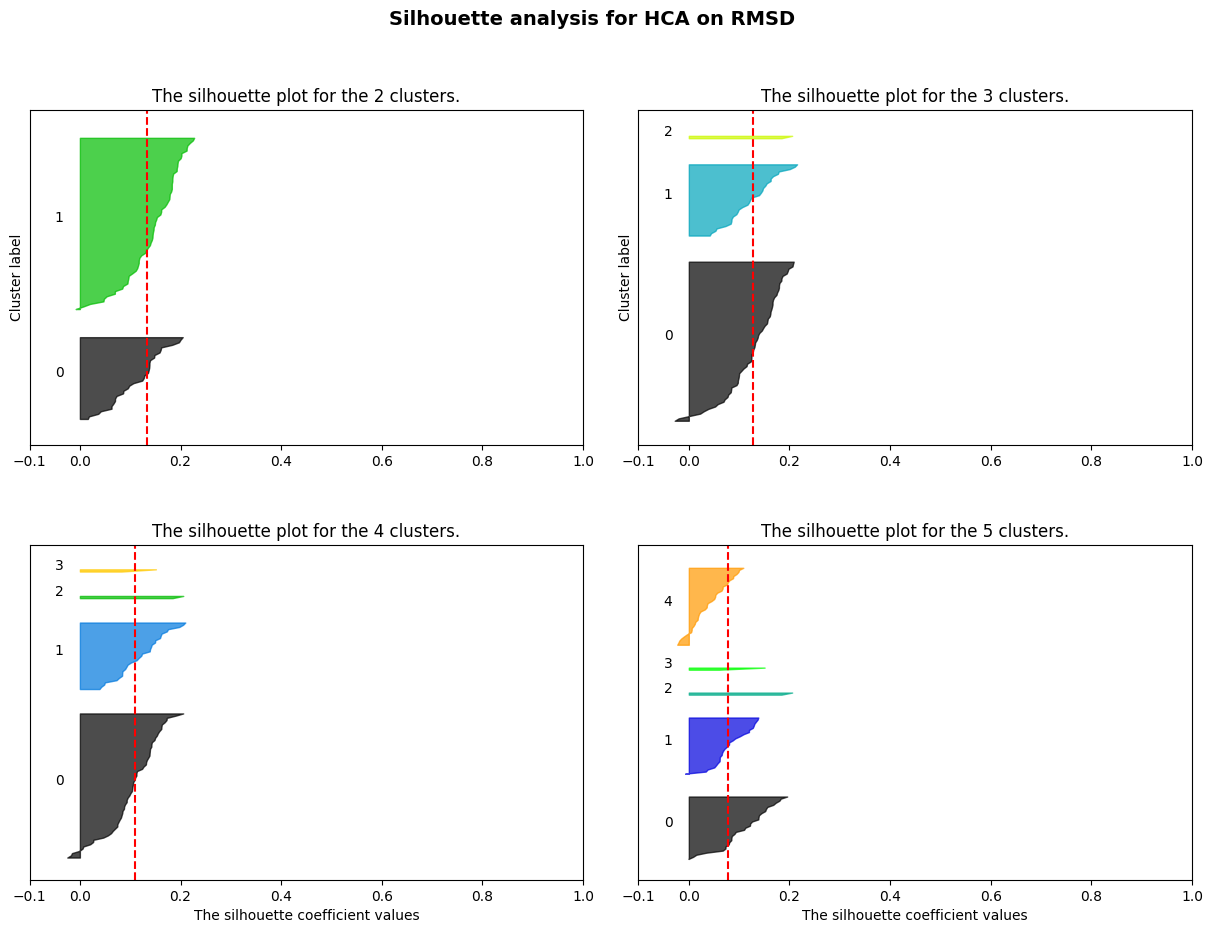

In [35]:
X = matrix_l2

fig, (ax1, ax2) = plt.subplots(2, 2,  figsize=(15, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.1)

range_n_clusters = {ax1[0]: 2, ax1[1]: 3, ax2[0]:  4, ax2[1]: 5}

for ax_n, n_clusters in range_n_clusters.items():

    ax = ax_n
    # Create a subplot with 1 row and 2 columns

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete', metric='precomputed')
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels, metric='precomputed')
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='precomputed')

    y_lower = 10


    for i in range(n_clusters):

        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title(f"The silhouette plot for the {n_clusters} clusters.")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


ax1[0].set_ylabel("Cluster label")
ax1[1].set_ylabel("Cluster label")
ax2[0].set_xlabel("The silhouette coefficient values")
ax2[1].set_xlabel("The silhouette coefficient values")

plt.suptitle(
      "Silhouette analysis for HCA on RMSD",
      fontsize=14,
      fontweight="bold",
    )

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.06769151826645052
For n_clusters = 3 The average silhouette_score is : 0.07205251253609768
For n_clusters = 4 The average silhouette_score is : 0.04997586364542923


For n_clusters = 5 The average silhouette_score is : 0.04212083967509436


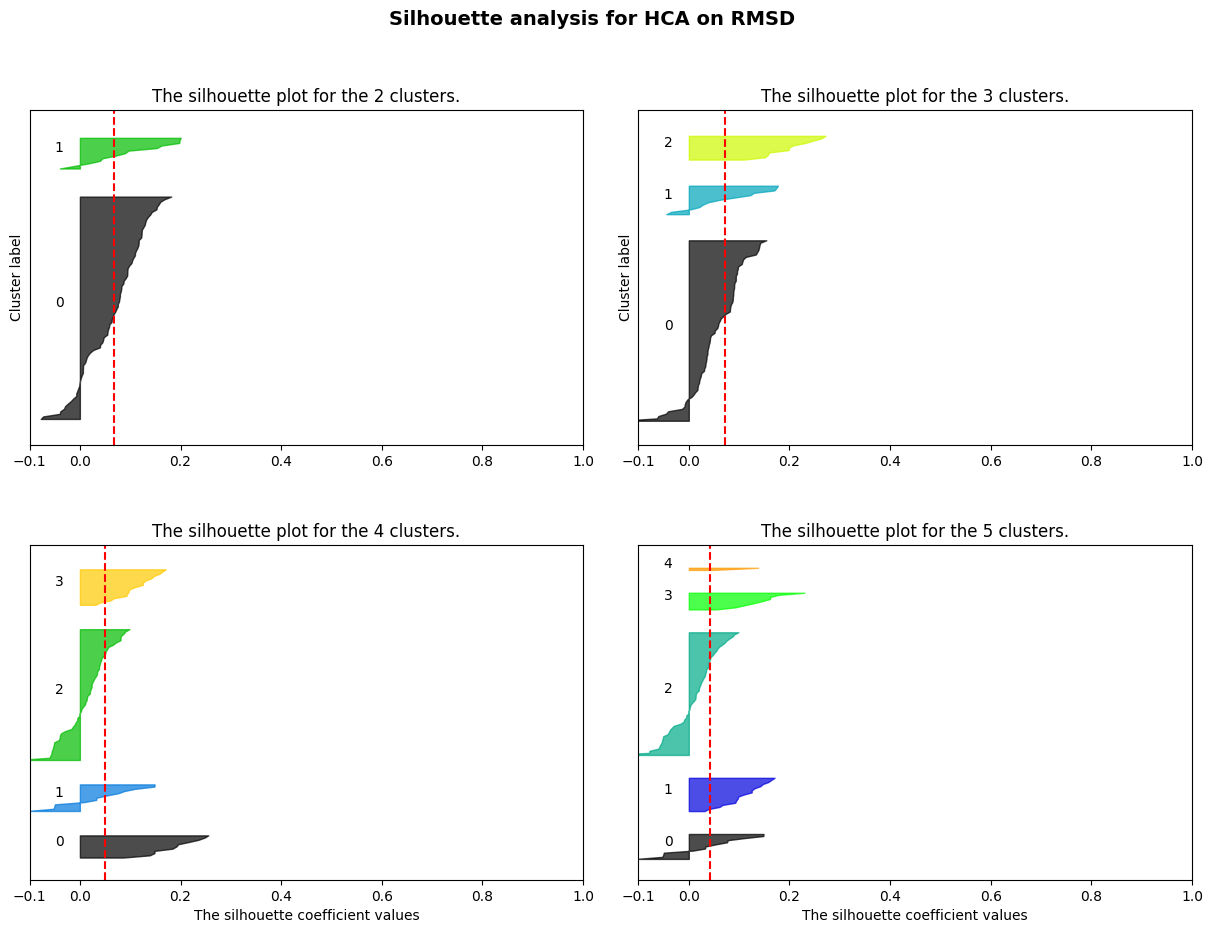

In [36]:
X = matrix_l3

fig, (ax1, ax2) = plt.subplots(2, 2,  figsize=(15, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.1)

range_n_clusters = {ax1[0]: 2, ax1[1]: 3, ax2[0]:  4, ax2[1]: 5}

for ax_n, n_clusters in range_n_clusters.items():

    ax = ax_n
    # Create a subplot with 1 row and 2 columns

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete', metric='precomputed')
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels, metric='precomputed')
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='precomputed')

    y_lower = 10


    for i in range(n_clusters):

        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title(f"The silhouette plot for the {n_clusters} clusters.")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


ax1[0].set_ylabel("Cluster label")
ax1[1].set_ylabel("Cluster label")
ax2[0].set_xlabel("The silhouette coefficient values")
ax2[1].set_xlabel("The silhouette coefficient values")

plt.suptitle(
      "Silhouette analysis for HCA on RMSD",
      fontsize=14,
      fontweight="bold",
    )

plt.show()

#### Clustering + dendrograms

In [38]:
h_cluster_l1 = AgglomerativeClustering(n_clusters=2, linkage='complete', metric='precomputed')
h_cluster_l2 = AgglomerativeClustering(n_clusters=2, linkage='complete', metric='precomputed')
h_cluster_l3 = AgglomerativeClustering(n_clusters=2, linkage='average', metric='precomputed')


hc_l1_rmsd = h_cluster_l1.fit_predict(matrix_l1)
hc_l2_rmsd = h_cluster_l2.fit_predict(matrix_l2)
hc_l3_rmsd = h_cluster_l3.fit_predict(matrix_l3)

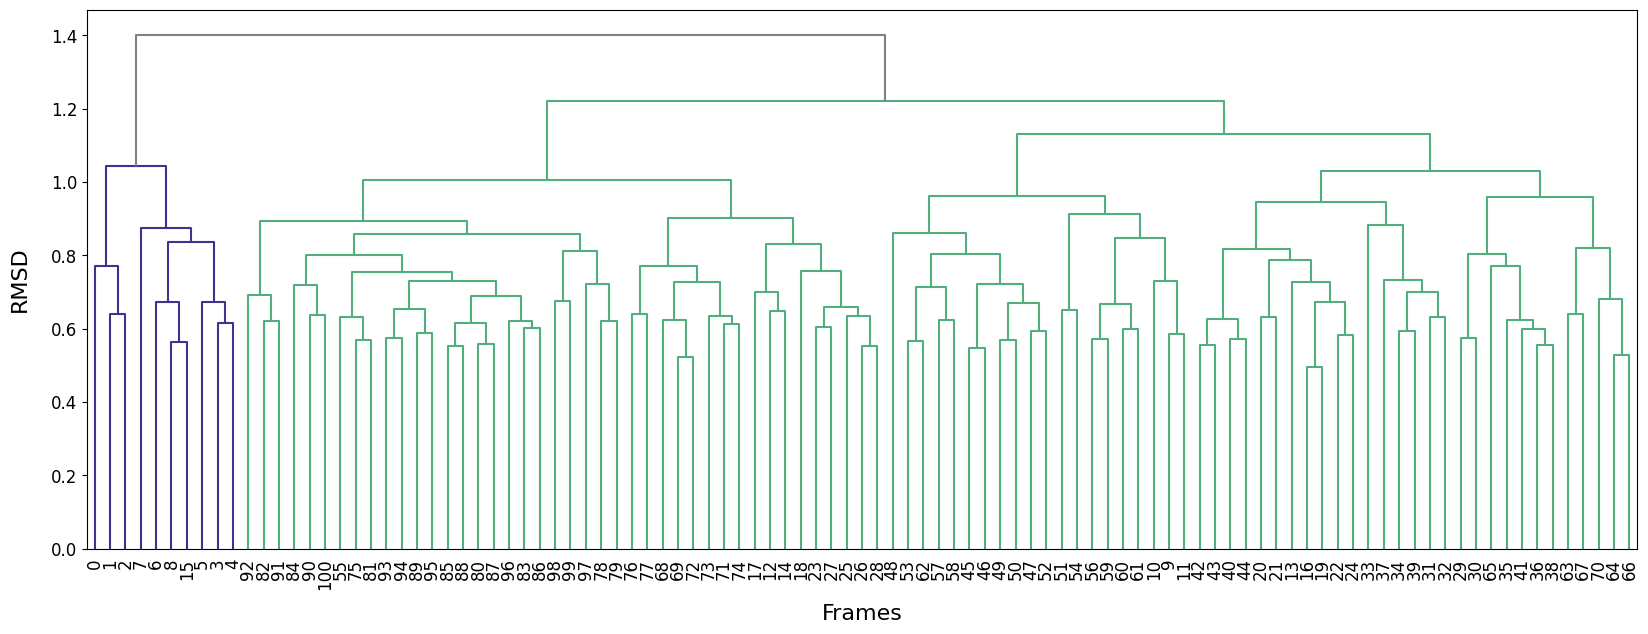

In [39]:
fig = plt.figure(figsize=(20, 7))

linkage_method = linkage(squareform(matrix_l1), method='complete')
dendrogram(linkage_method, color_threshold=1.3, above_threshold_color='grey')

pal = ['#3e338e', '#50af7c']

hierarchy.set_link_color_palette(pal)

plt.axhline(y=2, c='grey', lw=1, linestyle='dashed')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Frames", fontsize=16, labelpad=10)
plt.ylabel("RMSD", fontsize=16, labelpad=15)

plt.show()

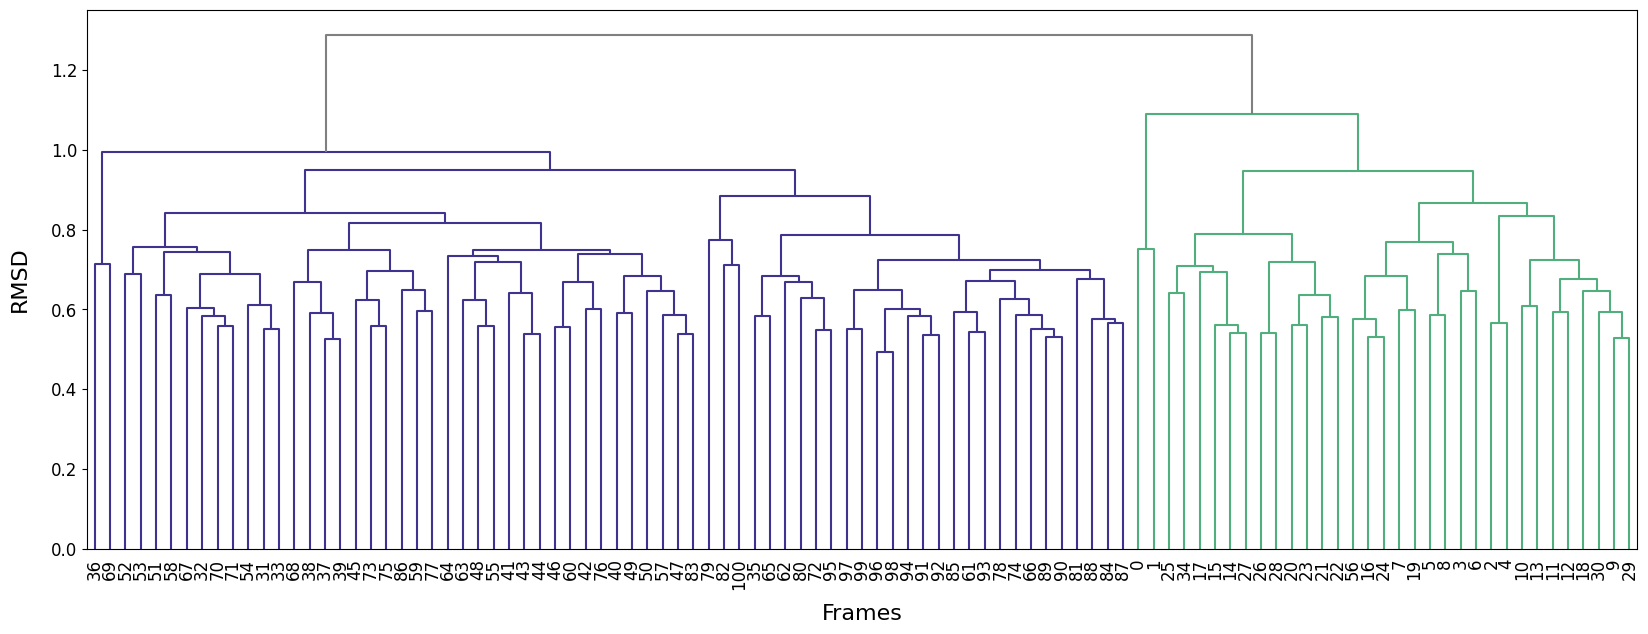

In [43]:
fig = plt.figure(figsize=(20, 7))

linkage_method = linkage(squareform(matrix_l2), method='complete')
dendrogram(linkage_method, color_threshold=1.1, above_threshold_color='grey')

pal = ['#3e338e', '#50af7c']

hierarchy.set_link_color_palette(pal)

plt.axhline(y=2, c='grey', lw=1, linestyle='dashed')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Frames", fontsize=16, labelpad=10)
plt.ylabel("RMSD", fontsize=16, labelpad=15)

plt.show()

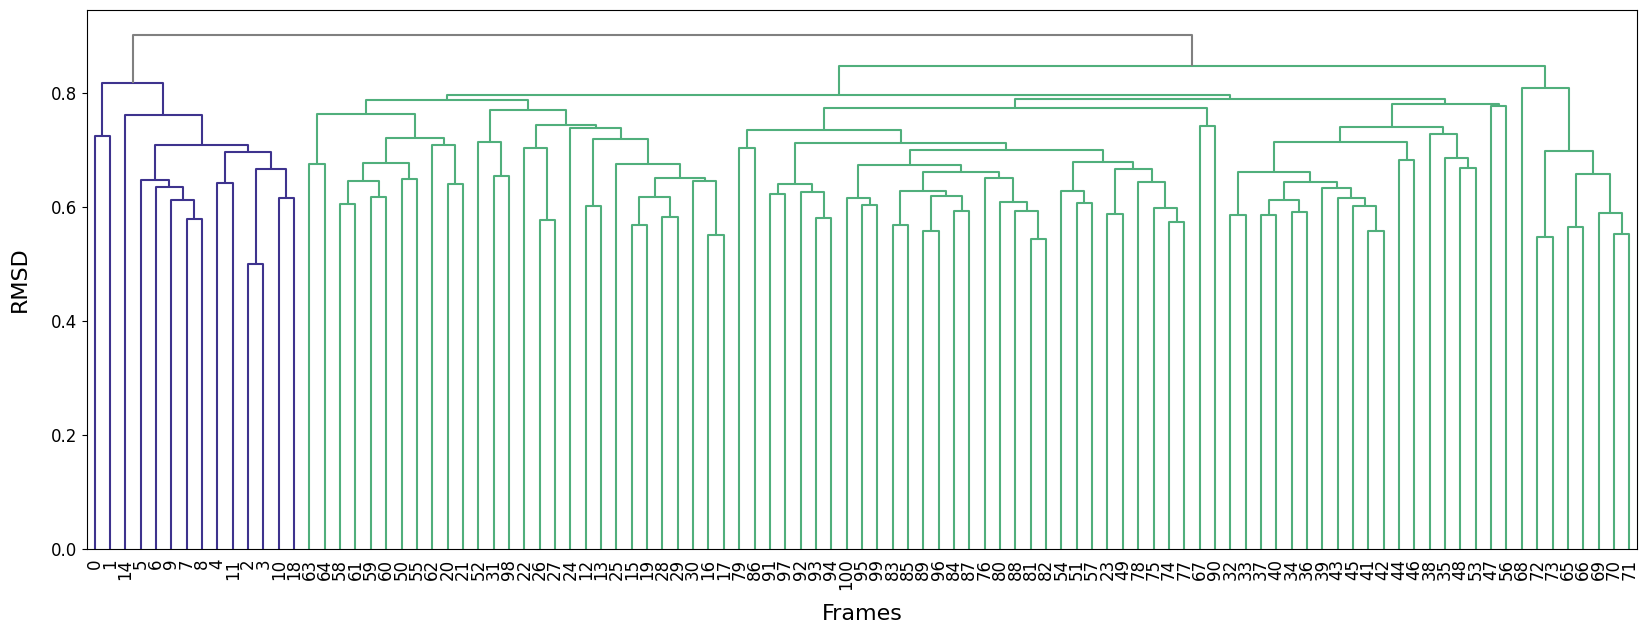

In [44]:
fig = plt.figure(figsize=(20, 7))

linkage_method = linkage(squareform(matrix_l3), method='average')
dendrogram(linkage_method, color_threshold=0.9, above_threshold_color='grey')

pal = ['#3e338e', '#50af7c']

hierarchy.set_link_color_palette(pal)

plt.axhline(y=2, c='grey', lw=1, linestyle='dashed')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Frames", fontsize=16, labelpad=10)
plt.ylabel("RMSD", fontsize=16, labelpad=15)

plt.show()

### GEODES

#### Number of clusters evaluation

For n_clusters = 2 The average silhouette_score is : 0.17074098635377116
For n_clusters = 3 The average silhouette_score is : 0.06312625190541854
For n_clusters = 4 The average silhouette_score is : 0.05675505178166501
For n_clusters = 5 The average silhouette_score is : 0.06365752537038345


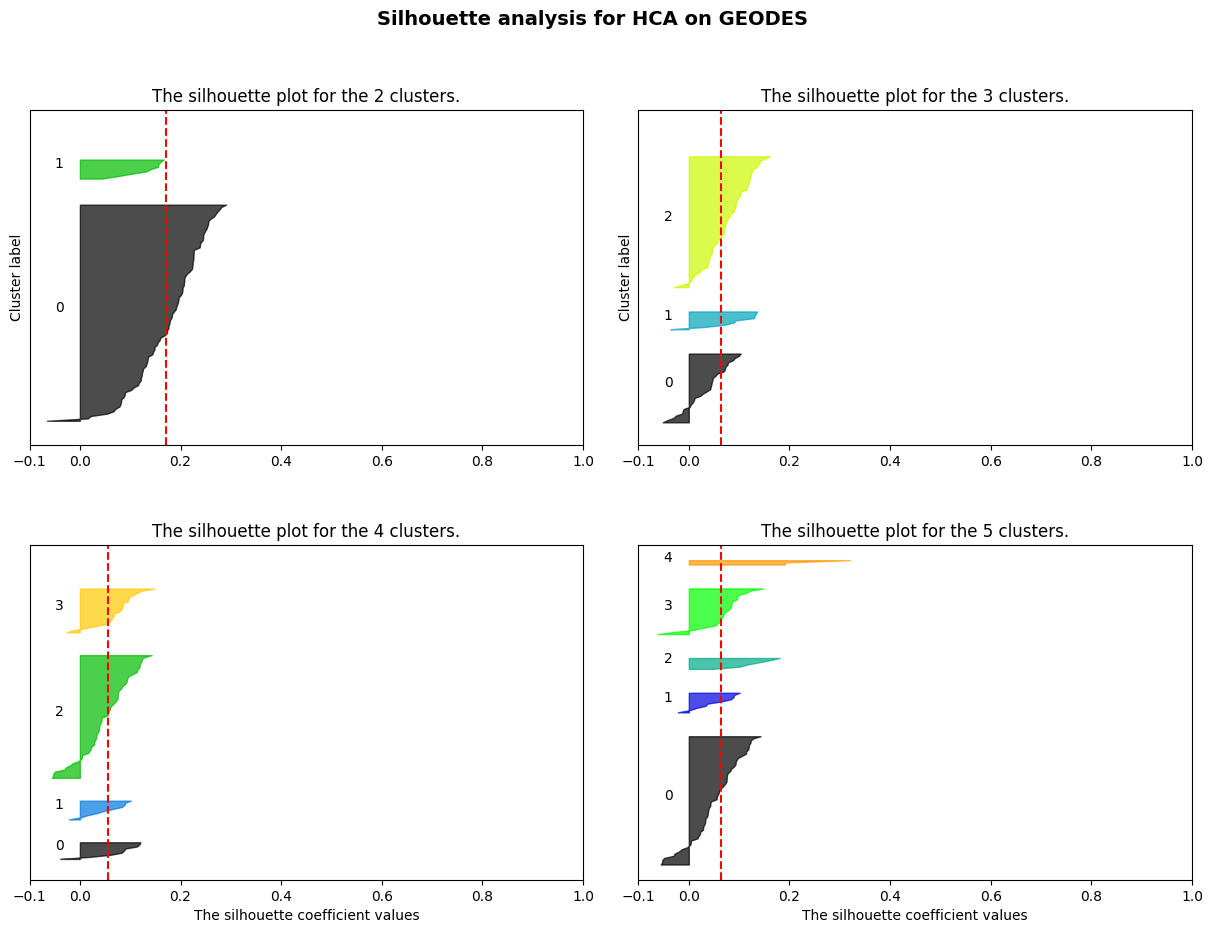

In [45]:
X = scaled_data['df_vd3_src_l1']

fig, (ax1, ax2) = plt.subplots(2, 2,  figsize=(15, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.1)

range_n_clusters = {ax1[0]: 2, ax1[1]: 3, ax2[0]:  4, ax2[1]: 5}

for ax_n, n_clusters in range_n_clusters.items():

    # Create a subplot with 1 row and 2 columns

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete', metric='euclidean')
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10

    ax = ax_n

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title(f"The silhouette plot for the {n_clusters} clusters.")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


ax1[0].set_ylabel("Cluster label")
ax1[1].set_ylabel("Cluster label")
ax2[0].set_xlabel("The silhouette coefficient values")
ax2[1].set_xlabel("The silhouette coefficient values")

plt.suptitle(
      "Silhouette analysis for HCA on GEODES",
      fontsize=14,
      fontweight="bold",
    )

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.2551017450627907
For n_clusters = 3 The average silhouette_score is : 0.07938761652846933
For n_clusters = 4 The average silhouette_score is : 0.06459784053208828
For n_clusters = 5 The average silhouette_score is : 0.036301085822166484


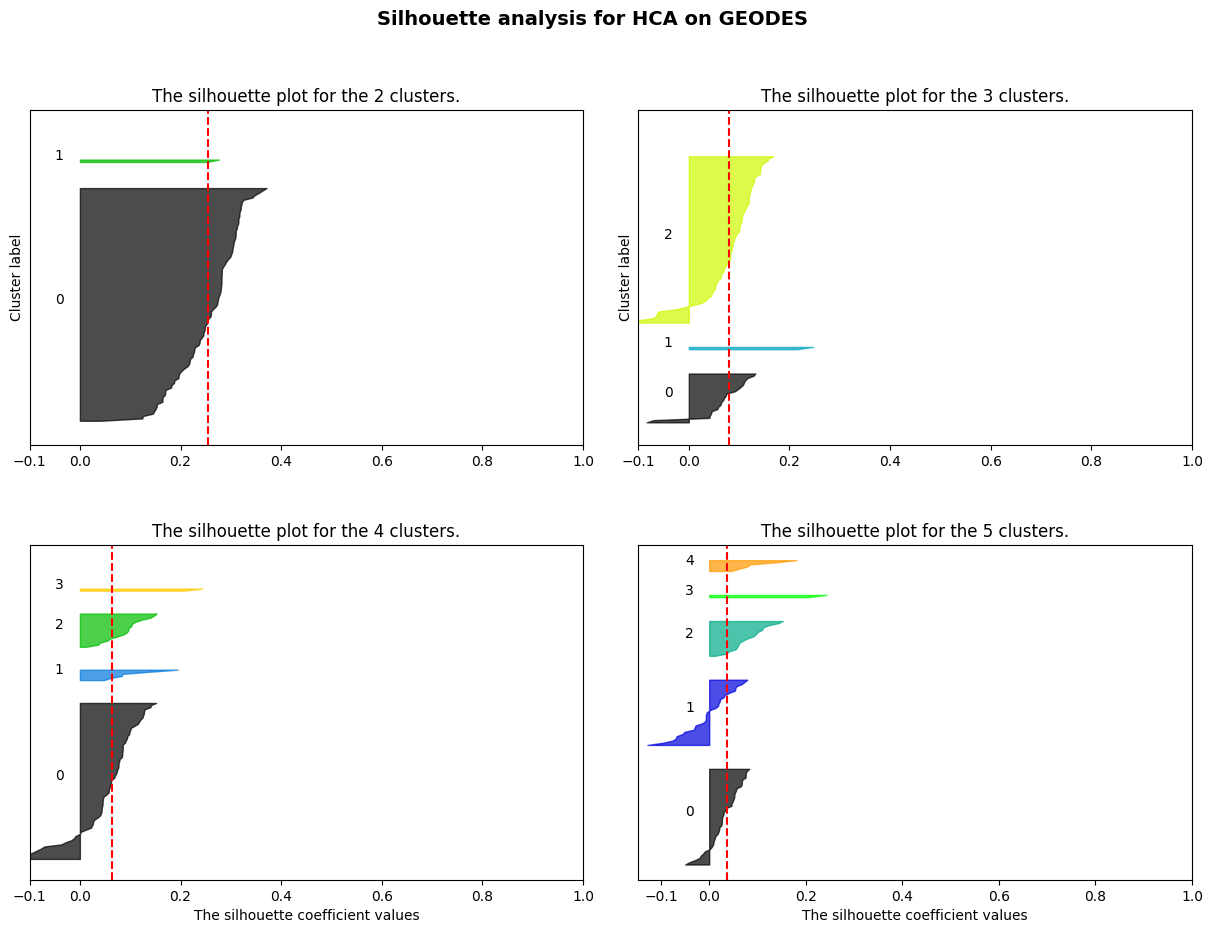

In [46]:
X = scaled_data['df_vd3_src_l2']

fig, (ax1, ax2) = plt.subplots(2, 2,  figsize=(15, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.1)

range_n_clusters = {ax1[0]: 2, ax1[1]: 3, ax2[0]:  4, ax2[1]: 5}

for ax_n, n_clusters in range_n_clusters.items():

    # Create a subplot with 1 row and 2 columns

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete', metric='euclidean')
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10

    ax = ax_n

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title(f"The silhouette plot for the {n_clusters} clusters.")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


ax1[0].set_ylabel("Cluster label")
ax1[1].set_ylabel("Cluster label")
ax2[0].set_xlabel("The silhouette coefficient values")
ax2[1].set_xlabel("The silhouette coefficient values")

plt.suptitle(
      "Silhouette analysis for HCA on GEODES",
      fontsize=14,
      fontweight="bold",
    )

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.08148131331084763
For n_clusters = 3 The average silhouette_score is : 0.053509747311524934
For n_clusters = 4 The average silhouette_score is : 0.04506948804564061
For n_clusters = 5 The average silhouette_score is : 0.03760229268605483


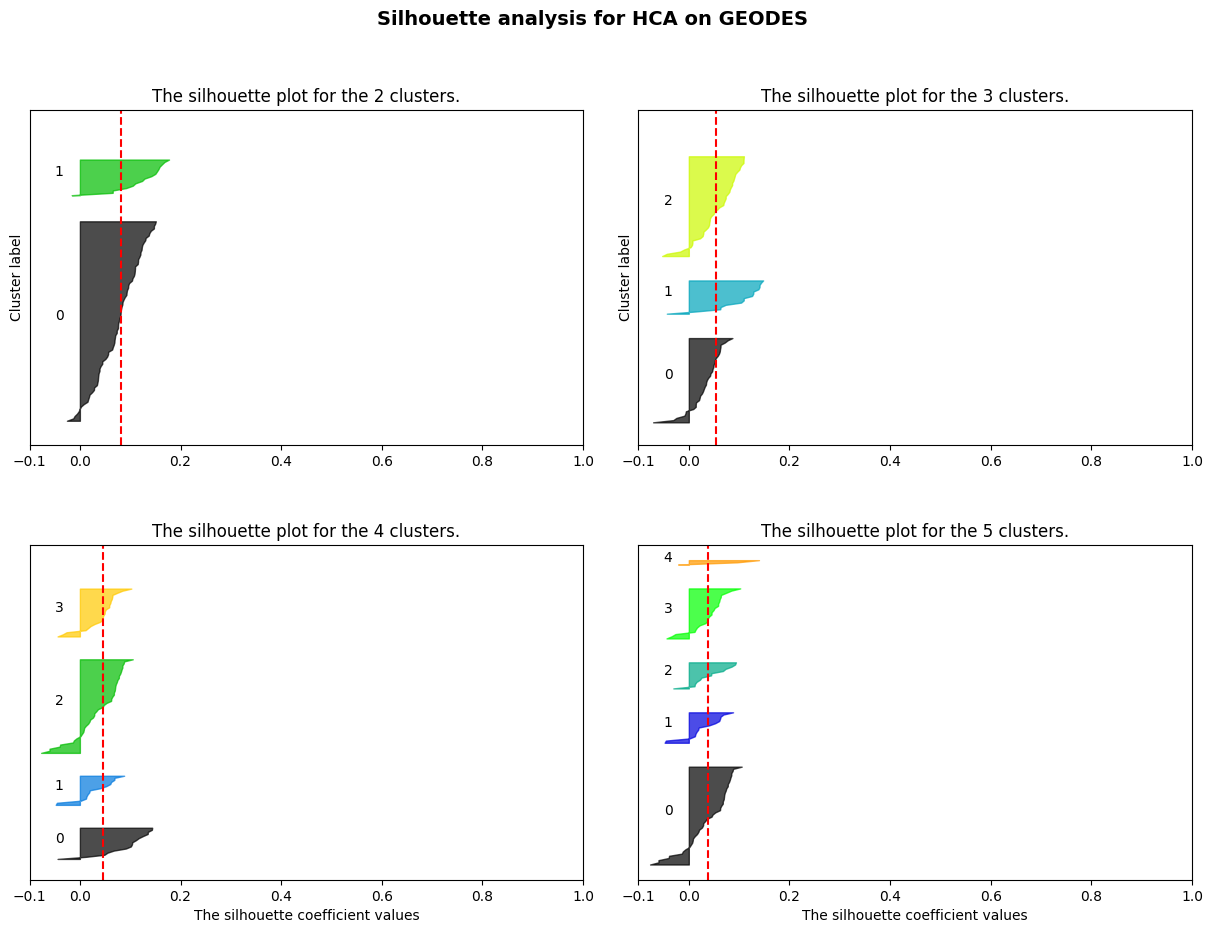

In [47]:
X = scaled_data['df_vd3_src_l3']

fig, (ax1, ax2) = plt.subplots(2, 2,  figsize=(15, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.1)

range_n_clusters = {ax1[0]: 2, ax1[1]: 3, ax2[0]:  4, ax2[1]: 5}

for ax_n, n_clusters in range_n_clusters.items():

    # Create a subplot with 1 row and 2 columns

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete', metric='euclidean')
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10

    ax = ax_n

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title(f"The silhouette plot for the {n_clusters} clusters.")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


ax1[0].set_ylabel("Cluster label")
ax1[1].set_ylabel("Cluster label")
ax2[0].set_xlabel("The silhouette coefficient values")
ax2[1].set_xlabel("The silhouette coefficient values")

plt.suptitle(
      "Silhouette analysis for HCA on GEODES",
      fontsize=14,
      fontweight="bold",
    )

plt.show()

#### Clustering + dendrograms

In [50]:
h_cluster_l1 = AgglomerativeClustering(n_clusters=2, linkage='complete', distance_threshold=None, metric='euclidean')
h_cluster_l2 = AgglomerativeClustering(n_clusters=2, linkage='ward', distance_threshold=None, metric='euclidean')
h_cluster_l3 = AgglomerativeClustering(n_clusters=2, linkage='complete', distance_threshold=None, metric='euclidean')


hc_l1 = h_cluster_l1.fit_predict(scaled_data['df_vd3_src_l1'])
hc_l2 = h_cluster_l2.fit_predict(scaled_data['df_vd3_src_l2'])
hc_l3 = h_cluster_l3.fit_predict(scaled_data['df_vd3_src_l3'])

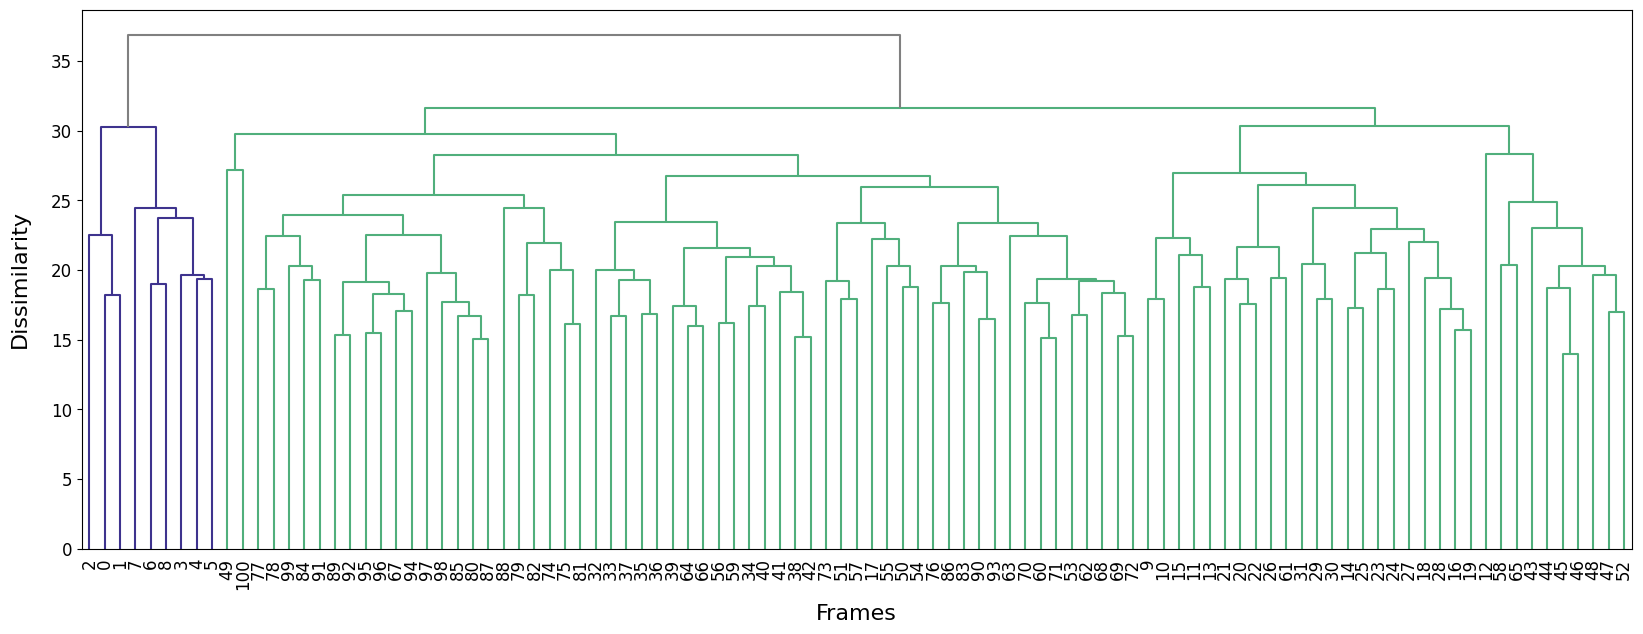

In [52]:
fig = plt.figure(figsize=(20, 7))

linkage_method = linkage(scaled_data['df_vd3_src_l1'], method ='complete', metric='euclidean')

pal = ['#3e338e', '#50af7c']

hierarchy.set_link_color_palette(pal)
dendrogram(linkage_method, color_threshold=35, above_threshold_color='grey')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Frames", fontsize=16, labelpad=10)
plt.ylabel("Dissimilarity", fontsize=16, labelpad=15)

plt.show()

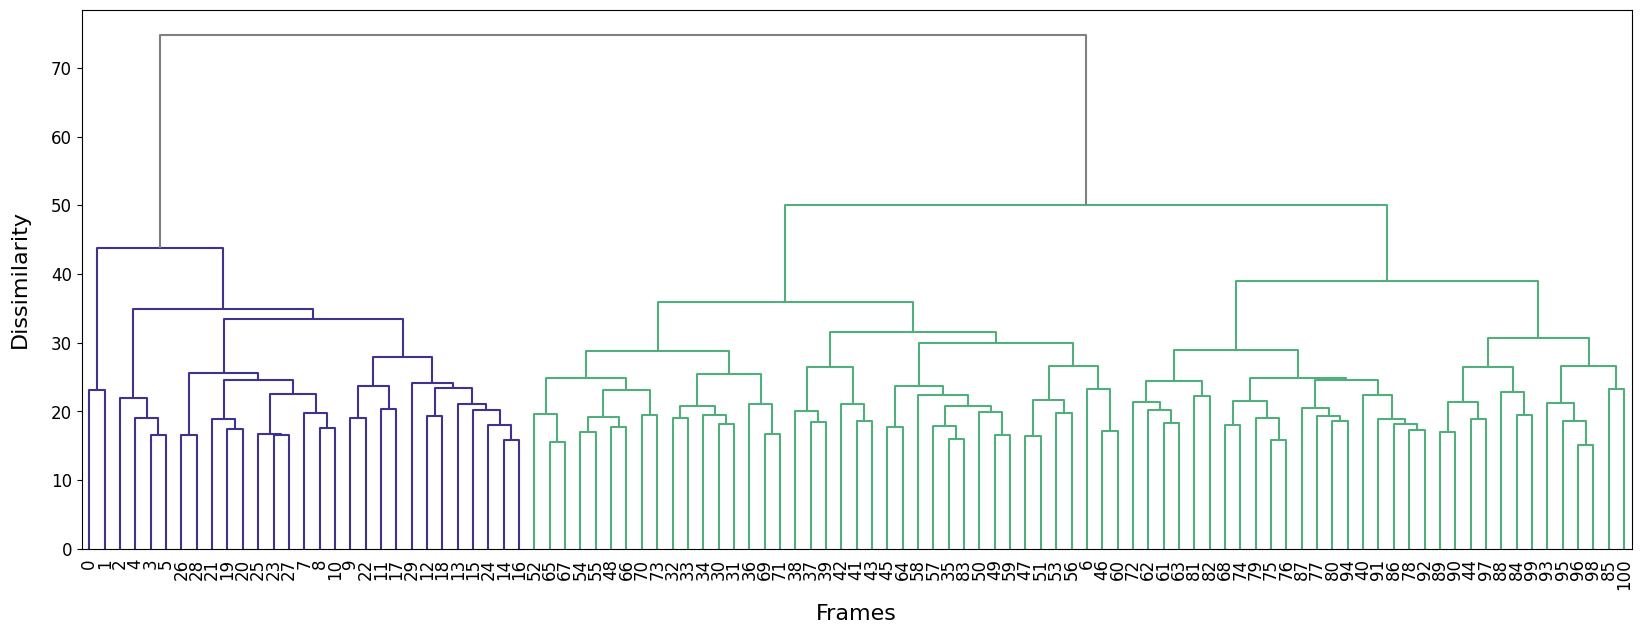

In [54]:
fig = plt.figure(figsize=(20, 7))


linkage_method = linkage(scaled_data['df_vd3_src_l2'], method ='ward', metric='euclidean')

pal = ['#3e338e', '#50af7c']

hierarchy.set_link_color_palette(pal)
dendrogram(linkage_method, color_threshold=60,  above_threshold_color='grey')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Frames", fontsize=16, labelpad=10)
plt.ylabel("Dissimilarity", fontsize=16, labelpad=15)

plt.show()

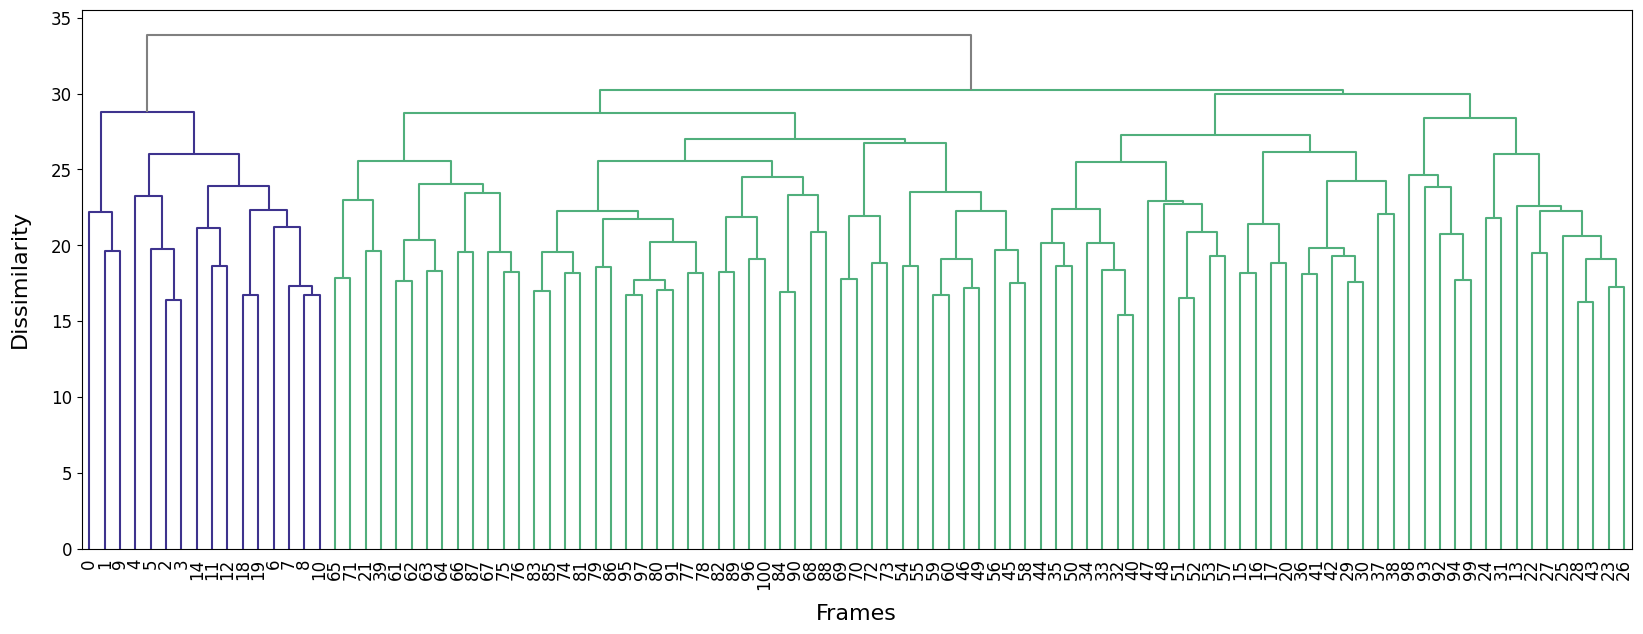

In [55]:
fig = plt.figure(figsize=(20, 7))

linkage_method = linkage(scaled_data['df_vd3_src_l3'], method ='complete', metric='euclidean')

pal = ['#3e338e', '#50af7c']

hierarchy.set_link_color_palette(pal)
dendrogram(linkage_method, color_threshold=32,  above_threshold_color='grey')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Frames", fontsize=16, labelpad=10)
plt.ylabel("Dissimilarity", fontsize=16, labelpad=15)

plt.show()

#### Rand index (comparing to RMSD)

In [51]:
print(rand_score(hc_l1, hc_l1_rmsd))
print(rand_score(hc_l2, hc_l2_rmsd))
print(rand_score(hc_l3, hc_l3_rmsd))

0.9801980198019802
0.9231683168316832
0.9607920792079208


## RMSD analysis

### RMSD (pairwise 2D-matrices) vs GEODES

In [86]:
# RMSD matrices were loaded in HAC section for dendrograms

# GEODES distance matrix calculation

l1_dist_mult = distance_matrix(scaled_data['df_vd3_src_l1'].values, scaled_data['df_vd3_src_l1'].values)
l2_dist_mult = distance_matrix(scaled_data['df_vd3_src_l2'].values, scaled_data['df_vd3_src_l2'].values)
l3_dist_mult = distance_matrix(scaled_data['df_vd3_src_l3'].values, scaled_data['df_vd3_src_l3'].values)

In [87]:
fig = make_subplots(rows=2, cols=3, horizontal_spacing=0.06, vertical_spacing=0.07,
                    subplot_titles=("L1", "L2", "L3", "", "", ""))

color_continuous_scale = 'haline'
r_scale=True

############################

fig.append_trace(go.Heatmap(z=l1_dist_mult, zmin=15, zmax=35,
                            showscale=False,
                            #colorbar=dict(orientation='h', len=0.32, x=0.14, y=0.2, thickness=15),
                            colorscale = color_continuous_scale,
                            reversescale=r_scale,
                            ), row=1, col=1)

fig.append_trace(go.Heatmap(z=l2_dist_mult, zmin=15, zmax=35,
                            showscale=False,
                            #colorbar=dict(orientation='h', len=0.32, x=0.5, y=0.2, thickness=15),
                            colorscale = color_continuous_scale,
                            reversescale=r_scale,
                            ), row=1, col=2)

fig.append_trace(go.Heatmap(z=l3_dist_mult, zmin=15, zmax=35,
                            colorbar=dict(orientation='v', len=0.5, y=0.76, thickness=15, dtick=5),
                            colorscale=color_continuous_scale,
                            reversescale=r_scale,
                            ), row=1, col=3)

############################

fig.append_trace(go.Heatmap(z=matrix_l1.to_numpy(), zmin=0.5, zmax=1.3,
                            showscale=False,
                            #colorbar=dict(orientation='h', len=0.33, x=0.16, y=-0.35, thickness=15),
                            colorscale = color_continuous_scale,
                            reversescale=r_scale,
                            ), row=2, col=1)

fig.append_trace(go.Heatmap(z=matrix_l2.to_numpy(), zmin=0.5, zmax=1.3,
                            showscale=False,
                            #colorbar=dict(orientation='h', len=0.51, x=0.50, y=-0.35, thickness=15),
                            colorscale = color_continuous_scale,
                            reversescale=r_scale,
                            ), row=2, col=2)

fig.append_trace(go.Heatmap(z=matrix_l3.to_numpy(),zmin=0.5,zmax=1.3,
                            colorbar=dict(orientation='v', len=0.5, y=0.23, thickness=15),
                            colorscale=color_continuous_scale,
                            reversescale=r_scale,
                            ), row=2, col=3)

###########################

fig.update_layout(template='simple_white',
                  title=dict(text="RMSD matrices vs GEODES matrices", font=dict(size=20)),
                  height=600, width=850)


fig.update_xaxes(dtick=10)
fig.update_yaxes(dtick=10)

fig.show()


In [88]:
# Mantel test for matrices

mantel_df = pd.DataFrame(index=['r','p', 'z'])

mantel_df['L1'] = [x for x in mantel.test(l1_dist_mult[np.triu_indices(101, k = 1)], matrix_l1.to_numpy()[np.triu_indices(101, k = 1)], method='pearson', tail='upper', perms=10000)]
mantel_df['L2'] = [x for x in mantel.test(l2_dist_mult[np.triu_indices(101, k = 1)], matrix_l2.to_numpy()[np.triu_indices(101, k = 1)], method='pearson', tail='upper', perms=10000)]
mantel_df['L3'] = [x for x in mantel.test(l3_dist_mult[np.triu_indices(101, k = 1)], matrix_l3.to_numpy()[np.triu_indices(101, k = 1)], method='pearson', tail='upper', perms=10000)]

mantel_df

,L1,L2,L3
r,0.699011,0.751412,0.661124
p,0.000100,0.000100,0.000100
z,12.914534,13.241510,14.575406


### RMSD (simple 1D-array form) vs GEODES

In [65]:
df_rmsd_md_l1 = pd.read_csv('rmsd_rmsf/rmsd_l1.dat', sep='\s+', decimal='.').shift(periods=1, axis="columns").drop(['#'], axis=1)
df_rmsd_md_l1['Ligand'] = 'VD3'
df_rmsd_md_l1['CoA'] = 'SRC1'
df_rmsd_md_l1['Motif'] = 'L1'
df_rmsd_md_l1['Complex'] = 'VDR-SRC1-L1'

df_rmsd_md_l2 = pd.read_csv('rmsd_rmsf/rmsd_l2.dat', sep='\s+', decimal='.').shift(periods=1, axis="columns").drop(['#'], axis=1)
df_rmsd_md_l2['Ligand'] = 'VD3'
df_rmsd_md_l2['CoA'] = 'SRC1'
df_rmsd_md_l2['Motif'] = 'L2'
df_rmsd_md_l2['Complex'] = 'VDR-SRC1-L2'

df_rmsd_md_l3 = pd.read_csv('rmsd_rmsf/rmsd_l3.dat', sep='\s+', decimal='.').shift(periods=1, axis="columns").drop(['#'], axis=1)
df_rmsd_md_l3['Ligand'] = 'VD3'
df_rmsd_md_l3['CoA'] = 'SRC1'
df_rmsd_md_l3['Motif'] = 'L3'
df_rmsd_md_l3['Complex'] = 'VDR-SRC1-L3'

In [66]:
rmsd_df = pd.concat([df_rmsd_md_l1, df_rmsd_md_l2,df_rmsd_md_l3], ignore_index=True)
rmsd_df['frame#'] = rmsd_df['frame#'].apply(lambda x: x / 100)

rmsd_df

,frame#,Prot_CA,Prot_Backbone,Prot_Sidechain,Prot_All_Heavy,Lig_wrt_Protein,Lig_wrt_Ligand,Ligand,CoA,Motif,Complex
0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,VD3,SRC1,L1,VDR-SRC1-L1
1,0.01,0.701,0.717,1.159,0.853,0.600,0.293,VD3,SRC1,L1,VDR-SRC1-L1
2,0.02,0.744,0.766,1.244,0.920,0.496,0.265,VD3,SRC1,L1,VDR-SRC1-L1
3,0.03,0.730,0.760,1.330,0.941,0.348,0.308,VD3,SRC1,L1,VDR-SRC1-L1
4,0.04,0.798,0.824,1.385,1.017,0.564,0.260,VD3,SRC1,L1,VDR-SRC1-L1
...,...,...,...,...,...,...,...,...,...,...,...
2998,9.96,2.094,2.186,2.930,2.478,0.825,0.409,VD3,SRC1,L3,VDR-SRC1-L3
2999,9.97,2.259,2.350,3.047,2.621,1.078,0.430,VD3,SRC1,L3,VDR-SRC1-L3
3000,9.98,2.185,2.243,2.972,2.533,0.836,0.485,VD3,SRC1,L3,VDR-SRC1-L3
3001,9.99,2.217,2.271,2.976,2.554,0.799,0.456,VD3,SRC1,L3,VDR-SRC1-L3


In [69]:
n_colors = 11
colors = px.colors.sample_colorscale("RdBu", [n/(n_colors -1) for n in range(n_colors)])

fig = px.line(rmsd_df, x="frame#", y="Prot_CA", color='Complex',
              labels={"frame#": "Time, ns",
                     "Prot_CA": "RMSD, Å"},
              color_discrete_map={"VDR-SRC1-L1": '#faa920',
                                  "VDR-SRC1-L2": '#1b9894',
                                  "VDR-SRC1-L3": '#90c73d'},
              width=600, height=400
              )

fig.update_layout(template='simple_white',
                  xaxis = dict(tickmode = 'linear', dtick = 0.05),
                  font=dict(size=16),
                  showlegend=True,
                  legend=dict(font=dict(size=12),
                              title="",
                              orientation="v",
                              yanchor="top",
                              y=1,
                              xanchor="right",
                              x=1)
                )

fig.show()

In [73]:
# distance from all the points to frame 0 (GEODES)
l1_dist_tofirst = l1_dist_mult[0]
l2_dist_tofirst = l2_dist_mult[0]
l3_dist_tofirst = l3_dist_mult[0]

# distance from all the points to frame 0 (MD RMSD, 1st row of RMSD matrix)
matrix_l1_tofirst = matrix_l1.to_numpy()[0]
matrix_l2_tofirst = matrix_l2.to_numpy()[0]
matrix_l3_tofirst = matrix_l3.to_numpy()[0]

# distance from all the points to frame 0 (MD RMSD, CA atoms but not only helices)
rmsd_l1_md = df_rmsd_md_l1['Prot_CA'].to_numpy()[0::10]
rmsd_l2_md = df_rmsd_md_l2['Prot_CA'].to_numpy()[0::10]
rmsd_l3_md = df_rmsd_md_l3['Prot_CA'].to_numpy()[0::10]

In [77]:
# Pearson correlation

print('Correlation coefficient between GEODES and MD RMSD all CA atoms:')
print(pearsonr(l1_dist_tofirst, rmsd_l1_md))
print(pearsonr(l2_dist_tofirst, rmsd_l2_md))
print(pearsonr(l3_dist_tofirst, rmsd_l3_md))
print('\n')
print('For helices-only correlation coefficient is higher:')
print(pearsonr(l1_dist_tofirst, matrix_l1_tofirst))
print(pearsonr(l2_dist_tofirst, matrix_l2_tofirst))
print(pearsonr(l3_dist_tofirst, matrix_l3_tofirst))

Correlation coefficient between GEODES and MD RMSD all CA atoms:
PearsonRResult(statistic=np.float64(0.6706666274400139), pvalue=np.float64(1.688187566347259e-14))
PearsonRResult(statistic=np.float64(0.7959886851377891), pvalue=np.float64(2.6036330118541042e-23))
PearsonRResult(statistic=np.float64(0.7648681155683447), pvalue=np.float64(1.2841535631928684e-20))


For helices-only correlation coefficient is higher:
PearsonRResult(statistic=np.float64(0.7846428457654248), pvalue=np.float64(2.8111530349295815e-22))
PearsonRResult(statistic=np.float64(0.8880309609774809), pvalue=np.float64(3.51764461349852e-35))
PearsonRResult(statistic=np.float64(0.8703765703852845), pvalue=np.float64(3.1642787892189346e-32))


In [81]:
fig = make_subplots(rows=2, cols=6,
                    subplot_titles=("Molecular dynamics", "GEODES", "L1", "L2", "L3"),
                    specs=[
                        [{"colspan":3}, None, None, {"colspan":3}, None, None],
                        [{"colspan":2}, None, {"colspan":2}, None, {"colspan":2}, None]
                        ],
                    horizontal_spacing=0.12, vertical_spacing=0.22)


old_colors = ['#CB7053', '#608FB9', '#89A275']
colors = ['#faa920', '#1b9894', '#90c73d']

hel = [matrix_l1_tofirst, matrix_l2_tofirst, matrix_l3_tofirst]
desc = [l1_dist_tofirst, l2_dist_tofirst, l3_dist_tofirst]


for i in range(1,4):
  # Add traces for RMSD helices curve
  fig.add_trace(
      go.Scatter(x=np.arange(1, 101), y=hel[i-1],
                 mode='lines', name=f"L{i}",
                 #legendgroup = str(i),
                 showlegend=True,
                 line = dict(color=colors[i-1], width=2)),
                 row=1, col=1,
                )

  fig.add_trace(
      go.Scatter(x=np.arange(1, 101), y=desc[i-1],
                 mode='lines', name=f"L{i}",
                 #legendgroup = str(i),
                 showlegend=False,
                 line = dict(color=colors[i-1], width=2)),
                 row=1, col=4
                )


for i in range(1,4):
  # Add traces for descr vs rmsd_hel scatter correlation
  next_col=2*i+1
  fig.add_trace(
      go.Scatter(y=desc[i-1], x=hel[i-1],
                 mode='markers',
                 #legendgroup = str(i),
                 showlegend=False,
                 marker_color=colors[i-1]),
                 row=2, col=next_col-2
                )


for i in range(1,4):
  next_col=2*i+1
  slope, intercept, r_value, p_value, std_err = stats.linregress(hel[i-1],desc[i-1])

  print('Slope:', slope, 'Intercept:', intercept, 'r_value:', r_value)

  # Add traces for descriptors curve
  fig.add_trace(
      go.Scatter(x=hel[i-1], y=slope*hel[i-1]+intercept,
                 mode='lines', name=f"L{i}",
                 #legendgroup = str(i),
                 showlegend=False,
                 line = dict(color=colors[i-1], width=2)),
                 row=2, col=next_col-2,
                )

# Set x-axis title

fig.update_xaxes(title_text="frames", title_font=dict(size=14), range=[0, 100], dtick=10, row=1)
fig.update_xaxes(range=[0.6, 1.3], dtick=0.1, title_text="RMSD α-helices, Å", showticklabels=True,
                 title_font=dict(size=14), row=2)

# Set y-axes titles

fig.update_yaxes(range=[0, 1.5], dtick=0.25, title_text="RMSD α-helices, Å", ticksuffix = "  ", showticklabels=True,
                 title_font=dict(size=16), row=1, col=1)


fig.update_yaxes(range=[0, 40], dtick=10, title_text="Distance, GEODES", ticksuffix = "  ", showticklabels=True,
                 title_font=dict(size=16), row=1, col=4)

fig.update_yaxes(range=[14, 40], dtick=5, title_text="Distance, GEODES", ticksuffix = "  ", showticklabels=True, title_font=dict(size=16),  row=2)
fig.update_yaxes(range=[14, 40], dtick=5, title_text="Distance, GEODES", ticksuffix = "  ", showticklabels=True, title_font=dict(size=16), row=2)
fig.update_yaxes(range=[14, 40], dtick=5, title_text="Distance, GEODES", ticksuffix = "  ", showticklabels=True, title_font=dict(size=16), row=2)

fig.update_yaxes(title_text="Distance, GEODES", showticklabels=True,
                 title_font=dict(size=16), row=2, col=1, ticksuffix = "  ")


fig.update_layout(template='simple_white',
                  legend=dict(font=dict(size=16),
                              orientation="h",
                              yanchor="top",
                              xanchor="left", y=1.2, x=0),
                  height=600, width=1100)


fig.show()

Slope: 19.36834328111384 Intercept: 8.831982686820552 r_value: 0.7846428457654253
Slope: 23.707018757081848 Intercept: 6.67573991076339 r_value: 0.8880309609774807
Slope: 23.47880460583885 Intercept: 4.984031410237147 r_value: 0.8703765703852843


## RMSF analysis

In [97]:
rmsf_vd3_src_l1 = pd.read_csv('rmsd_rmsf/rmsf_l1.dat', sep='\s+', decimal='.').shift(periods=1, axis="columns").drop(['#'], axis=1)
rmsf_vd3_src_l1['Ligand'] = 'VD3'
rmsf_vd3_src_l1['CoA'] = 'SRC1'
rmsf_vd3_src_l1['Motif'] = 'L1'

rmsf_vd3_src_l2 = pd.read_csv('rmsd_rmsf/rmsf_l2.dat', sep='\s+', decimal='.').shift(periods=1, axis="columns").drop(['#'], axis=1)
rmsf_vd3_src_l2['Ligand'] = 'VD3'
rmsf_vd3_src_l2['CoA'] = 'SRC1'
rmsf_vd3_src_l2['Motif'] = 'L2'

rmsf_vd3_src_l3 = pd.read_csv('rmsd_rmsf/rmsf_l3.dat', sep='\s+', decimal='.').shift(periods=1, axis="columns").drop(['#'], axis=1)
rmsf_vd3_src_l3['Ligand'] = 'VD3'
rmsf_vd3_src_l3['CoA'] = 'SRC1'
rmsf_vd3_src_l3['Motif'] = 'L3'

In [98]:
a = np.arange(118, 165)
b = np.arange(216, 428)
residues = np.concatenate((a,b), axis=0)
residues_x3 = np. concatenate((residues, residues, residues), axis=0)

resn=[str(r) for r in residues_x3]

rmsf_df = pd.concat([rmsf_vd3_src_l1[:259], rmsf_vd3_src_l2[:259], rmsf_vd3_src_l3[:259]], ignore_index=True)
rmsf_df['resn'] = resn
rmsf_df

,Residue#,Chain,ResName,LigandContact,CA,Backbone,Sidechain,All_Heavy,B-factor,Ligand,CoA,Motif,resn
0,0,A,ASP_118,No,7.572,7.360,8.830,8.151,20.240,VD3,SRC1,L1,118
1,1,A,SER_119,No,6.105,5.990,6.853,6.291,22.885,VD3,SRC1,L1,119
2,2,A,LEU_120,No,4.591,4.364,5.372,4.841,22.885,VD3,SRC1,L1,120
3,3,A,ARG_121,No,3.369,3.163,5.091,4.461,19.888,VD3,SRC1,L1,121
4,4,A,PRO_122,No,1.689,1.741,2.397,2.008,16.120,VD3,SRC1,L1,122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,254,A,GLY_423,No,0.617,0.660,0.742,0.660,22.238,VD3,SRC1,L3,423
773,255,A,ASN_424,No,0.859,1.039,1.746,1.427,0.000,VD3,SRC1,L3,424
774,256,A,GLU_425,No,1.202,1.470,1.865,1.712,0.000,VD3,SRC1,L3,425
775,257,A,ILE_426,No,2.633,2.659,3.855,3.244,0.000,VD3,SRC1,L3,426


In [99]:
import plotly.express as px

fig = px.line(rmsf_df, x="resn", y="CA", color='Motif',
              labels={"resn": "Residue",
                     "CA": "RMSF, Å"},
              color_discrete_map={"L1": '#faa920',
                                  "L2": '#1b9894',
                                  "L3": '#90c73d'},
              width=1000, height=600
)

fig.update_layout(template='simple_white',
                  xaxis = dict(tickmode = 'linear', dtick = 15),
                  font=dict(size=16),
                  legend=dict(font=dict(size=12),
                              title="",
                              orientation="h",
                              yanchor="top",
                              y=1.05,
                              xanchor="right",
                              x=1)
                  )

fig.show()

In [101]:
hel_dict = {'H1':np.arange(127,143), 'H2':np.arange(149,153), "H3n":np.arange(218,222), "H3":np.arange(226,247), 'H4':np.arange(257,266),
            'H5':np.arange(268,279), 'H6':np.arange(298,303), "H7":np.arange(308,323), 'H8':np.arange(328,339),
            'H9':np.arange(350,370), 'H10': np.arange(379,398), "H11": np.arange(397,407),
            'Hx':np.arange(411,414), 'H12':np.arange(417,424)}

avg_hel_rmsf = []
bins = [0, 0.45, 0.65, 0.85]
labels = ['Low', 'Medium', 'High']

for i in range(1,4):
  avg=[]
  for key, item in hel_dict.items():
    str_item = [str(x) for x in item]
    motif='L'+str(i)
    avg.append(rmsf_df[(rmsf_df['resn'].isin(str_item)) & (rmsf_df['Motif']==motif)].mean(numeric_only=True)['CA'])
  avg_hel_rmsf.append(avg)

avg_hel_rmsf_l1 = pd.DataFrame({'Helix': hel_dict.keys(), 'RMSF':avg_hel_rmsf[0], 'motif':'L1', 'label': pd.cut(avg_hel_rmsf[0], bins=bins, labels=labels)})
avg_hel_rmsf_l2 = pd.DataFrame({'Helix': hel_dict.keys(), 'RMSF':avg_hel_rmsf[1], 'motif':'L2', 'label': pd.cut(avg_hel_rmsf[1], bins=bins, labels=labels)})
avg_hel_rmsf_l3 = pd.DataFrame({'Helix': hel_dict.keys(), 'RMSF':avg_hel_rmsf[2], 'motif':'L3', 'label': pd.cut(avg_hel_rmsf[2], bins=bins, labels=labels)})

In [102]:
fig = go.Figure(data=[
    go.Bar(name='L1', x=avg_hel_rmsf_l1['Helix'], y=avg_hel_rmsf_l1['RMSF'], marker_color='#faa920'),
    go.Bar(name='L2', x=avg_hel_rmsf_l2['Helix'], y=avg_hel_rmsf_l2['RMSF'], marker_color='#1b9894'),
    go.Bar(name='L3', x=avg_hel_rmsf_l3['Helix'], y=avg_hel_rmsf_l3['RMSF'], marker_color='#90c73d'),
    go.Scatter(name='Total RMSF median', x=avg_hel_rmsf_l1['Helix'],
               y=[0.567,0.567,0.567,0.567,0.567,0.567,0.567,0.567,0.567, 0.567,0.567,0.567,0.567,0.567],
              mode='lines', marker_color='black', line = dict(color='darkred', width=2, dash='dash'))
    ])


fig.update_layout(template='simple_white',barmode='group',
                  yaxis=dict(
                     title='RMSF,Å',
                     dtick=0.1,
                     titlefont_size=16),
                  font=dict(size=14),
                  legend=dict(font=dict(size=16),
                              orientation="h",
                              yanchor="top",
                              xanchor="right", y=1.2, x=1),
                  height=500, width=1000)

fig.show()